In [158]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import json
from dotmap import DotMap
import pandas as pd

%config InlineBackend.figure_format = 'retina'
plt.rcParams.update({'font.size': 15})

# https://www.kaggle.com/datasets/ruchi798/star-wars

In [159]:
episodes = []
factions = []
for i in range(1, 8):
    with open(f'data/interactions/starwars-episode-{i}-interactions-allCharacters.json') as f:
        episodes.append(DotMap(json.load(f)))
    try:
        with open(f'data/factions/factions_{i}.json') as f:
            factions.append(json.load(f))
    except:
        factions.append({})

outcomes = []
with open('data/outcomes.json') as f:
    outcomes = json.load(f)
    outcomes = [v for k, v in outcomes.items()]

In [160]:
networks = []
for i, episode in enumerate(episodes):
    G = nx.Graph()
    to_remove = []
    for node in episode.nodes:
        if len(factions[i]) > 0:
            if node.name in factions[i]['bad']:
                faction = 'bad'
            elif node.name in factions[i]['good']:
                faction = 'good'
            elif node.name in factions[i]['neutral']:
                faction = 'neutral'
            elif node.name in factions[i]['remove']:
                to_remove.append(node.name)
            else:
                raise Exception(f'Unknown faction for {node.name}')
        G.add_node(node.name, value=node.value, color=node.colour, faction=faction)
    for link in episode.links:
        G.add_edge((nl:=list(G.nodes))[link.source], nl[link.target], weight=link.value)
    for node in to_remove:
        G.remove_node(node)
    G = nx.subgraph(G, max(nx.connected_components(G), key=len))
    networks.append(G)

In [161]:
# For each network print the average degree, average clustering coefficient, and diameter
stats = pd.DataFrame()

for i, G in enumerate(networks):
    stats.loc[f'Ep {i+1}', 'avg_degree'] = np.mean([d for n, d in G.degree()])
    stats.loc[f'Ep {i+1}', 'max_degree'] = max([d for n, d in G.degree()])
    stats.loc[f'Ep {i+1}', 'avg_clustering'] = nx.average_clustering(G)
    stats.loc[f'Ep {i+1}', 'diameter'] = nx.diameter(G)

stats
roman = {1: 'I', 2: 'II', 3: 'III', 4: 'IV', 5: 'V', 6: 'VI', 7: 'VII'}
for i, G in enumerate(networks):
    print(f'{roman[i+1]} &', ' & '.join([f'{v:.2f}' for v in stats.loc[f'Ep {i+1}'].values]), '\\\\\\hline')

I & 7.24 & 26.00 & 0.74 & 4.00 \\\hline
II & 6.25 & 21.00 & 0.70 & 4.00 \\\hline
III & 5.42 & 14.00 & 0.62 & 4.00 \\\hline
IV & 5.71 & 15.00 & 0.70 & 3.00 \\\hline
V & 5.24 & 12.00 & 0.63 & 4.00 \\\hline
VI & 5.50 & 15.00 & 0.61 & 4.00 \\\hline
VII & 6.81 & 16.00 & 0.70 & 4.00 \\\hline


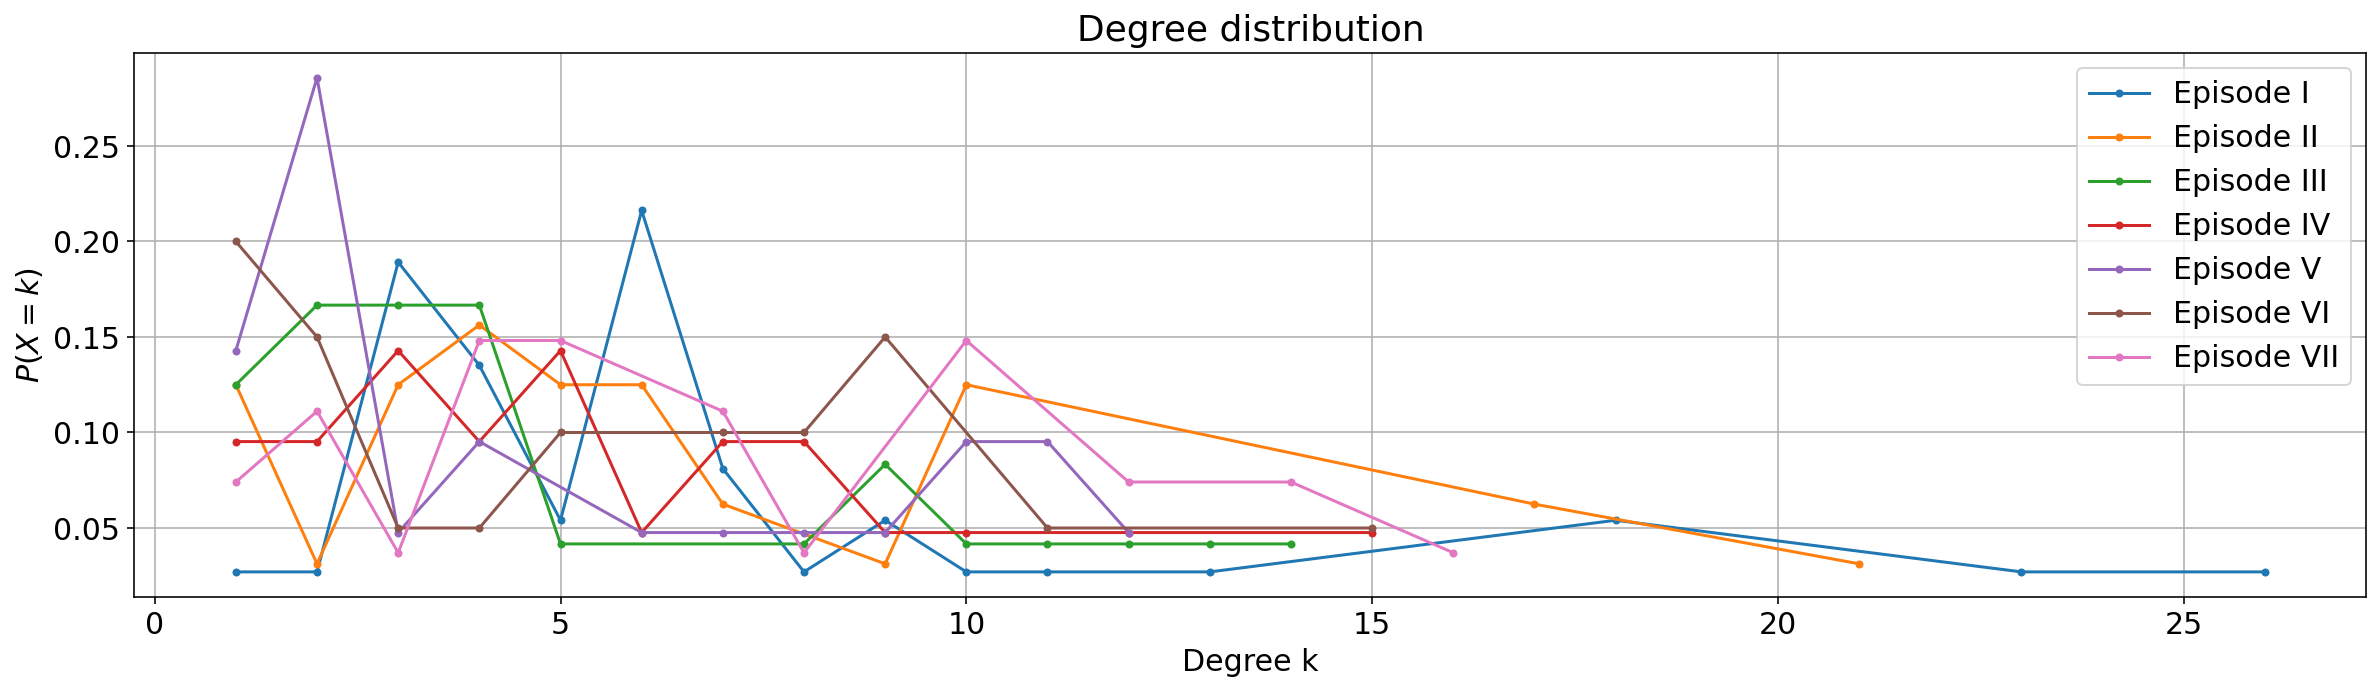

In [162]:
plt.figure(figsize=(20, 5))
for i, G in enumerate(networks):
    name = f'Episode {roman[i+1]}'
    sorted_degrees = sorted([d for _, d in G.degree()])
    degree_df = np.unique(sorted_degrees, return_counts=True)
    plt.plot(degree_df[0], degree_df[1] / sum(degree_df[1]), '.-', label=name)
plt.xlabel('Degree k')
plt.ylabel('$P(X=k)$')
plt.title('Degree distribution')
plt.legend()
plt.grid()

In [ ]:
import netgraph

fig, ax = plt.subplots(4, 2, figsize=(20, 30))
ax = ax.flatten()

faction_to_color = {
    'bad' : 'tab:red',
    'good' : 'tab:blue',
    'neutral' : 'tab:green',
}

for episode in range(1, 8):
    G = networks[episode-1]

    _G = G.copy()
    for edge in _G.edges:
        _G.edges[edge]['weight'] = 0

    net_ax = ax[episode-1] if episode < 7 else ax[7]

    # Draw the graph using node faction as community
    netgraph.Graph(_G,
        ax=net_ax,
        node_edge_width=0,
        node_layout='community',
        node_layout_kwargs=dict(node_to_community=(node_to_community:={node: G.nodes[node]['faction'] for node in G.nodes})),
        node_color={node: faction_to_color[faction] for node, faction in node_to_community.items()},
        node_size={node: np.log(G.nodes[node]['value'] + 1) * 2 for node in G.nodes},
        node_alpha=0.5,
        node_labels={node: node.replace(' ', '\n') for node in G.nodes},
        node_label_fontdict=dict(size=12),
        edge_layout='bundled',
        edge_alpha=0.3,
        edge_width=0.5,
        edge_color={edge: faction_to_color[node_to_community[edge[0]]] if node_to_community[edge[0]] == node_to_community[edge[1]] else 'gray' for edge in G.edges},
        prettify=True,
    )

    net_ax.set_title(f'Episode {roman[episode]}')
    net_ax.set_xticks([])
    net_ax.set_yticks([])
    net_ax.set_aspect('equal')

fig.delaxes(ax[6])
fig.tight_layout()
fig.patch.set_facecolor('white')

In [164]:
stats = pd.DataFrame(columns=['episode'])
stats.set_index('episode', inplace=True)

for i, G in enumerate(networks):
    stats.loc[i+1, 'outcome'] = outcomes[i]
    
    for faction in [f for f in faction_to_color if f != 'neutral']:
        faction_G = G.subgraph([node for node in G.nodes if G.nodes[node]['faction'] == faction])
        faction_G = faction_G.subgraph(max(nx.connected_components(faction_G), key=len))

        faction = {
            'bad' : 'Dark',
            'good' : 'Light',
        }[faction]

        stats.loc[i+1, f'[{faction}] nodes'] = len(faction_G.nodes)
        stats.loc[i+1, f'[{faction}] edges'] = len(faction_G.edges)
        stats.loc[i+1, f'[{faction}] density'] = nx.density(faction_G)
        stats.loc[i+1, f'[{faction}] cliques'] = nx.graph_number_of_cliques(faction_G)
        stats.loc[i+1, f'[{faction}] diameter'] = nx.diameter(faction_G)
        stats.loc[i+1, f'[{faction}] efficiency'] = nx.global_efficiency(faction_G)
        stats.loc[i+1, f'[{faction}] connectivity'] = nx.average_node_connectivity(faction_G)
        stats.loc[i+1, f'[{faction}] assortativity'] = nx.degree_assortativity_coefficient(faction_G)
        stats.loc[i+1, f'[{faction}] avg degree'] = np.mean([degree for node, degree in faction_G.degree])
        stats.loc[i+1, f'[{faction}] avg clustering'] = nx.average_clustering(faction_G)
        stats.loc[i+1, f'[{faction}] avg closeness centrality'] = np.mean([nx.closeness_centrality(faction_G)[node] for node in faction_G.nodes])
        stats.loc[i+1, f'[{faction}] avg shortest path length'] = nx.average_shortest_path_length(faction_G)
        stats.loc[i+1, f'[{faction}] avg rich club coefficient'] = np.mean([v for d, v in nx.rich_club_coefficient(faction_G, normalized=False).items()])
        stats.loc[i+1, f'[{faction}] avg betweenness centrality'] = np.mean([nx.betweenness_centrality(faction_G)[node] for node in faction_G.nodes])
        stats.loc[i+1, f'[{faction}] avg second order degree centrality'] = np.mean([nx.second_order_centrality(faction_G)[node] for node in faction_G.nodes])
        # stats.loc[i+1, f'[{faction}]_avg_degree_centrality'] = np.mean([nx.degree_centrality(faction_G)[node] for node in faction_G.nodes])
        # stats.loc[i+1, f'[{faction}]_avg_eigenvector_centrality'] = np.mean([nx.eigenvector_centrality(faction_G)[node] for node in faction_G.nodes])
        # stats.loc[i+1, f'[{faction}]_avg_trophic_level'] = np.mean([nx.trophic_level(faction_G)[node] for node in faction_G.nodes])
        # stats.loc[i+1, f'[{faction}]_triangles'] = sum(nx.triangles(faction_G).values()) / 3
        # stats.loc[i+1, f'[{faction}]_transitivity'] = nx.transitivity(faction_G)
        # stats.loc[i+1, f'[{faction}]_avg_eccentricity'] = np.mean([nx.eccentricity(faction_G)[node] for node in faction_G.nodes])
        # stats.loc[i+1, f'[{faction}]_small_world_sigma'] = nx.sigma(faction_G)
        # stats.loc[i+1, f'[{faction}]_small_world_omega'] = nx.omega(faction_G)
        # stats.loc[i+1, f'[{faction}]_avg_effective_size'] = np.mean([v for k,v in nx.effective_size(faction_G).items()])
        # stats.loc[i+1, f'[{faction}]_avg_closeness_vitality'] = np.mean([v for k,v in nx.closeness_vitality(faction_G).items()])
        # stats.loc[i+1, f'[{faction}]_avg_wi'] = nx.wiener_index(faction_G)



    
    # Reorganize the columns such that the same stats are next to each other
    stats = stats.reindex(columns=['outcome'] + sorted([c for c in stats.columns if not c == 'outcome'], key=lambda x: ' '.join(x.split(' ')[1:])))

    # Replace all NaNs with 0
    stats = stats.fillna(0)

# stats.to_csv('stats.csv')

/Users/mike/.pyenv/versions/3.10.2/envs/dev/lib/python3.10/site-packages/networkx/algorithms/assortativity/correlation.py:298: RuntimeWarning: invalid value encountered in double_scalars
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)


In [165]:
# Remove columns from df
to_remove = [
    # 'good_avg_degree',
    # 'bad_transitivity',
]

stats = stats.drop(columns=to_remove)

In [166]:
outcome_map = {
    'good' : 1,
    'bad' : 0,
}

X = np.array(stats.drop('outcome', axis=1).values)
Y = stats['outcome'].map(outcome_map).values
names = stats.columns[1:]

      outcome  prediction  confidence
Ep 1        1           1    0.876578
Ep 2        1           1    0.500513
Ep 3        0           0    0.578484
Ep 4        1           1    0.907318
Ep 5        0           0    0.833556
Ep 6        1           1    0.715174
Ep 7        1           1    0.957911
Score: 1.0


/var/folders/l_/vnq08k4n0hn498fyp2mcvcsm0000gn/T/ipykernel_2653/1595609419.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(names, rotation=90)


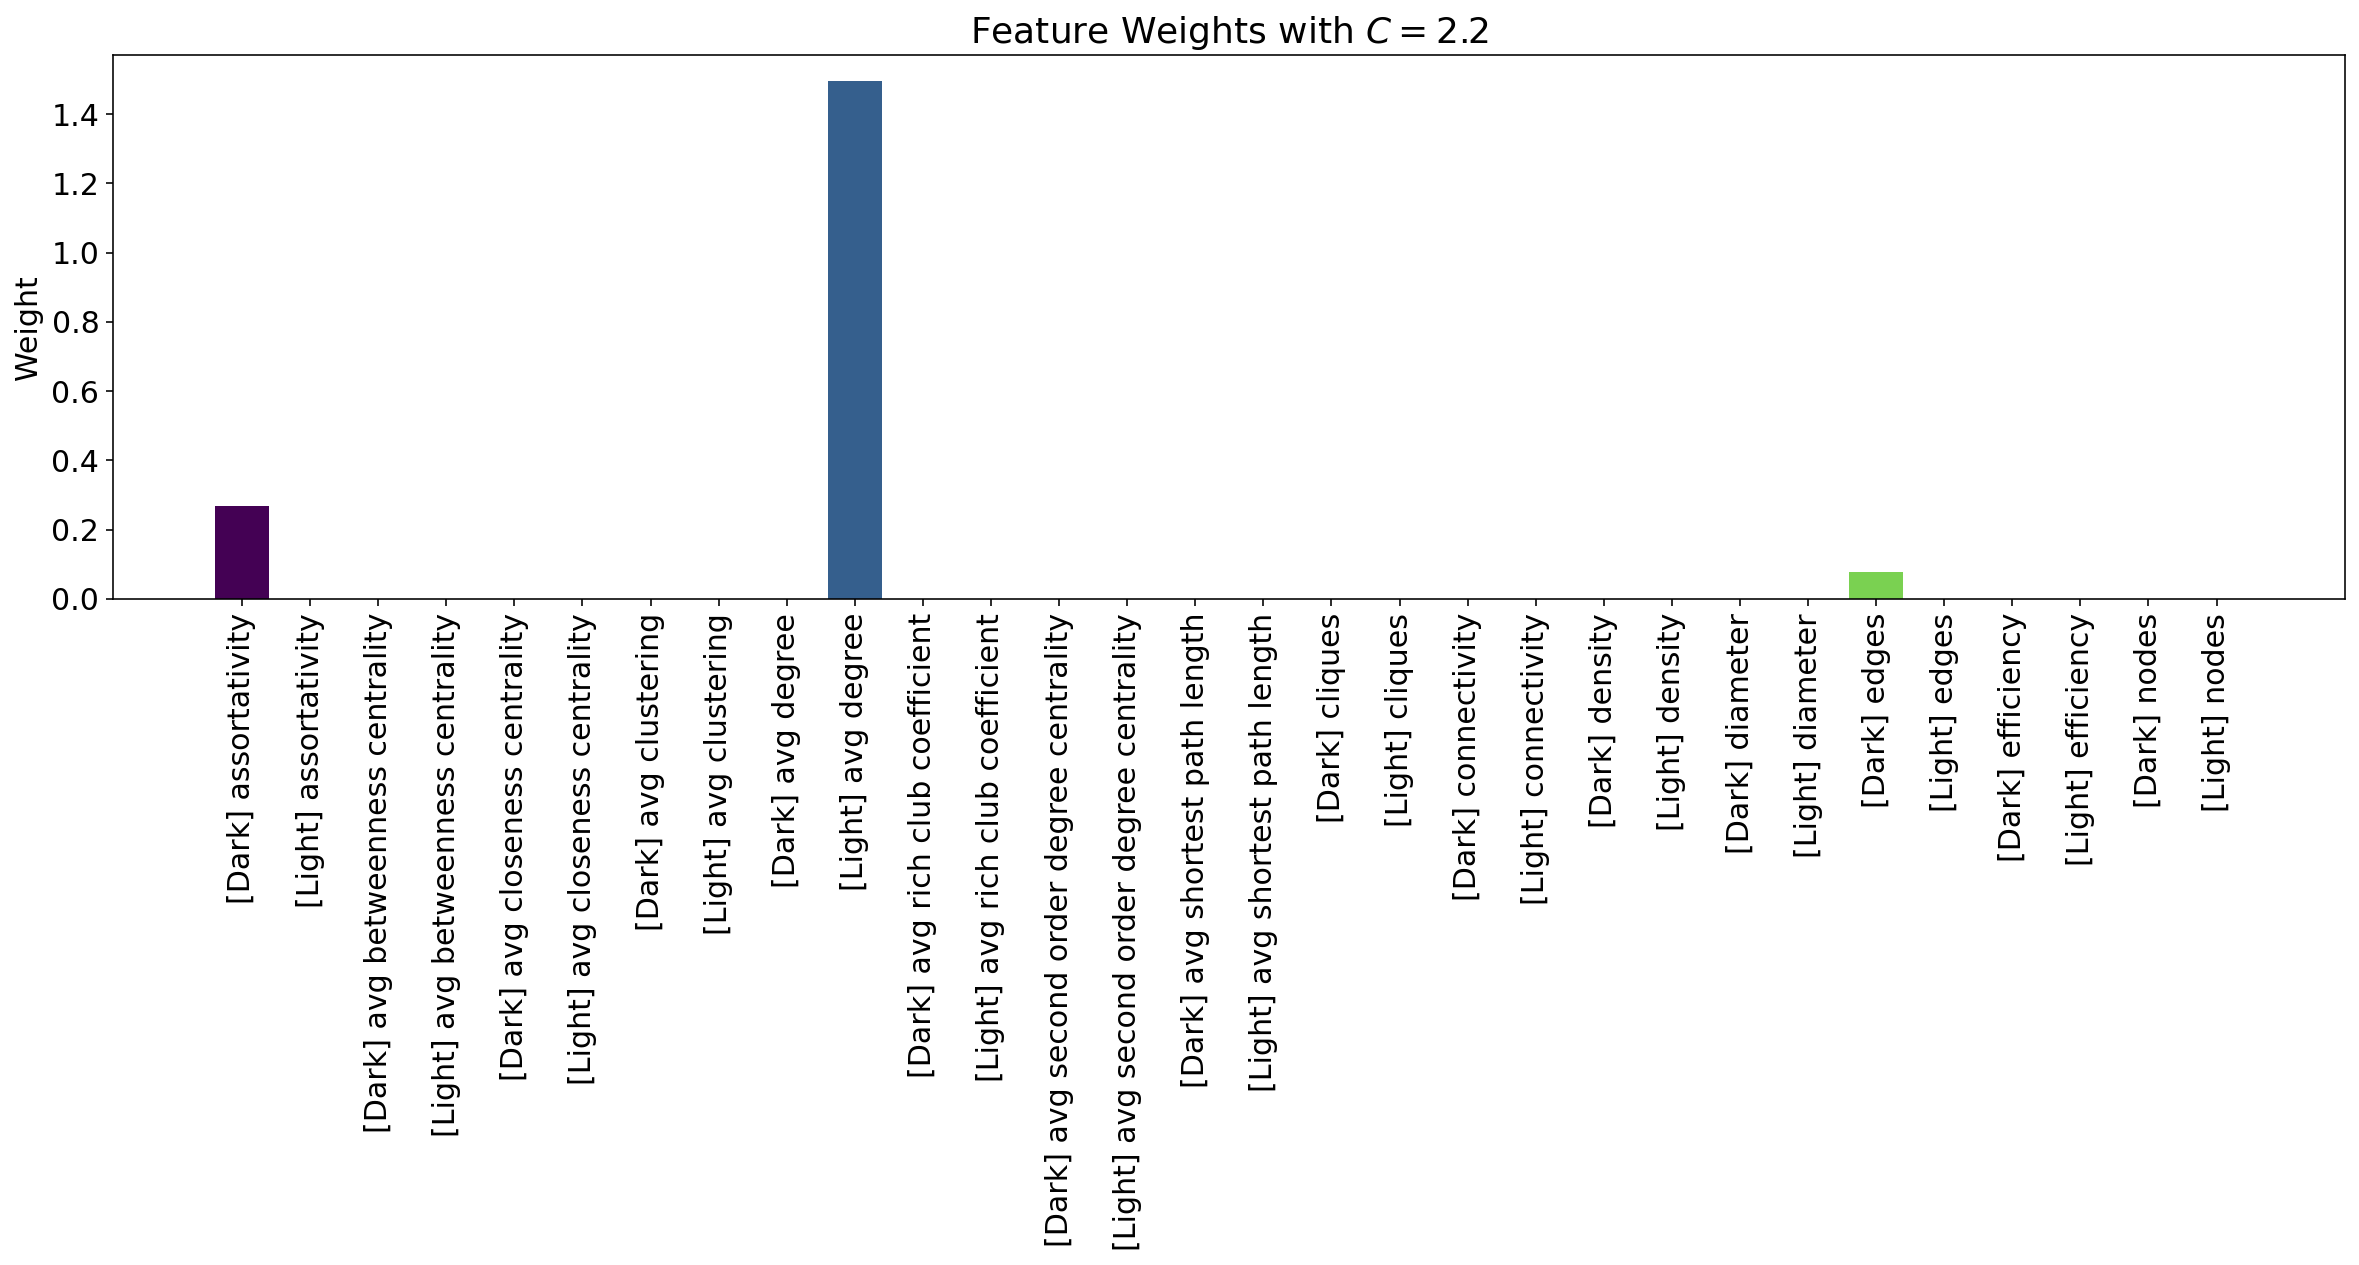

In [169]:
# Construct a linear model and optimize with lasso regularization
from sklearn.linear_model import Lasso, LinearRegression, LogisticRegression


# Normalize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

C = 2.2 
model = LogisticRegression(penalty='l1', solver='liblinear', C=C, max_iter=100, tol=1e-6, random_state=42)
model.fit(X, Y)

# Print each outcome and its coefficient
res = pd.DataFrame({'outcome': Y, 'prediction': model.predict(X)}, index=[f'Ep {i+1}' for i in range(len(Y))])
res['confidence'] = np.max(model.predict_proba(X), axis=1)
print(res)
color = '\033[92m' if all((np.array(res['outcome']) > 0) == (np.array(res['prediction']) > 0)) else '\033[91m'
print(f'{color}Score: {model.score(X, Y)}')

from matplotlib import cm
cmap = cm.get_cmap('viridis')
colors = [cmap(i/len(names)) for i in range(len(names))]

# Plot the coefficients
fig, ax = plt.subplots(figsize=(20, 5))
ax.set_title(f'Feature Weights with $C={C}$')
ax.bar(names, model.coef_[0], label='Coefficients', color=colors)
# ax.set_xlabel('Feature')
ax.set_ylabel('Weight')
ax.set_xticklabels(names, rotation=90)
# ax.grid()
plt.show()

In [170]:
metric_analysis = stats[[
    'outcome',
    '[Light] avg degree',
    '[Dark] avg degree',
    '[Light] assortativity',
    '[Dark] assortativity',
    '[Light] edges',
    '[Dark] edges',
]]

metric_analysis

,outcome,[Light] avg degree,[Dark] avg degree,[Light] assortativity,[Dark] assortativity,[Light] edges,[Dark] edges
episode,,,,,,,
1,good,6.190476,3.333333,-0.255039,-0.382979,65.0,10.0
2,good,5.000000,2.571429,-0.194684,-0.305344,35.0,9.0
3,bad,5.076923,1.600000,-0.312115,-0.666667,33.0,4.0
4,good,6.307692,2.000000,-0.228464,0.000000,41.0,3.0
5,bad,4.285714,2.666667,-0.302735,-0.763780,30.0,8.0
6,good,6.000000,1.500000,-0.415556,-1.000000,39.0,3.0
7,good,7.111111,2.666667,0.071032,-0.763780,64.0,8.0
